In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [29]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

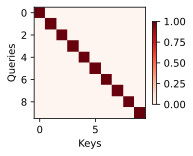

In [30]:
# 查询和键的索引相同时，注意力为1，其余为0。这是典型的自注意力机制中的一种情形，表示每个查询只会关注与其自己对应的键。
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [31]:
# Nadaraya-Watson 核回归
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x ** 0.8

# 训练集中加入噪声是为了模拟真实世界中数据的噪声，使得模型学习到的不仅是函数的形状，还要考虑到数据的波动。
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出

x_test = torch.arange(0, 5, 0.1)  # 测试样本
# 测试集通常不加噪声，因为我们假设在测试时数据是理想的，想要评估模型对“真实”规律的拟合能力。如果在测试集上加噪声，可能会影响评估的准确性，不能真实反映模型的泛化能力。
y_true = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数

In [32]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_true, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

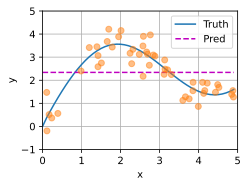

In [33]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

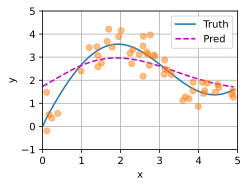

In [34]:
# 每一行都包含着相同的测试输入(例如: 同样的查询)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 每一行都包含着要在给定的每个查询的值(y_train)之间的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

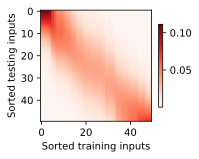

In [35]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [47]:
# 批量矩阵乘法
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y)

tensor([[[4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.]]])

In [48]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
# 返回一个新的张量,形状会在指定的dim维度上增加一个维度,新的维度大小为1。
# weights.unsqueeze(1).shape | values.unsqueeze(-1).shape (2, 1, 10) (2, 10, 1) 
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)) # (2, 1, 1)

tensor([[[ 4.5000]],

        [[14.5000]]])

In [57]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        print(f"queries.shape: {queries.shape}")
        print(f"keys.shape: {keys.shape}")
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数, "键-值"对个数)
        # reshape(-1),将张量的形状展平成一个一维向量
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [58]:
# 训练
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_title = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_title = y_train.repeat((n_train, 1))
# keys的形状: ('n_train', 'n_train'-1)
keys = X_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状: ('n_train', 'n_train'-1)
values = Y_title[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

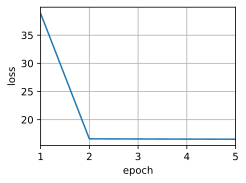

In [59]:
# 训练带参数的注意力汇聚模型时,使用平方损失函数和随机梯度下降。
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    # 清零梯度
    trainer.zero_grad()
    # 前向传播
    l = loss(net(x_train, keys, values), y_train)
    # 反向传播,计算梯度
    l.sum().backward()
    # 根据梯度更新参数
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

queries.shape: torch.Size([50])
keys.shape: torch.Size([50, 50])


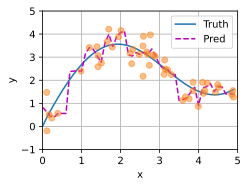

In [60]:
# 带噪声的训练数据
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

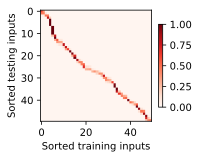

In [61]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')